# Test the parameter set of the Enertech cells
In this notebook, we show how to use pybamm to reproduce the experimental results for the Enertech cells (LCO-G). To see all of the models and submodels available in PyBaMM, please take a look at the documentation [here](https://pybamm.readthedocs.io/en/latest/source/models/index.html).

In [1]:
import pybamm
import os
import numpy as np
import matplotlib.pyplot as plt
os.chdir(pybamm.__path__[0]+'/..')

When you load a model in PyBaMM it builds by default. Building the model sets all of the model variables and sets up any variables which are coupled between different submodels: this is the process which couples the submodels together and allows one submodel to access variables from another. If you would like to swap out a submodel in an exisitng battery model you need to load it without building it by passing the keyword `build=False`

In [2]:
model = pybamm.lithium_ion.DFN(
    build=False,options = {"particle": "Fickian diffusion", "thermal": "lumped"}
)


We can get the parameter set `Ai2020` for the model, which includes the mechanical properties required by the mechanical model.

In [3]:
# param = model.default_parameter_values
chemistry = pybamm.parameter_sets.Ai2020

# # Below commands are used to add the mechanical parameters missing from other parameter sets 
# import pandas as pd
# mechanics = pd.read_csv("pybamm/input/parameters/lithium-ion/mechanicals/lico2_graphite_Ai2020/parameters.csv", 
#                        index_col=0, comment="#", skip_blank_lines=True, header=None)[1][1:].dropna().astype(float).to_dict()
# param.update(mechanics, check_already_exists=False)
param = pybamm.ParameterValues(chemistry=chemistry)
experiment05C = pybamm.Experiment(["Discharge at 0.5C until 3 V"])
experiment1C = pybamm.Experiment(["Discharge at 1C until 3 V"])
experiment2C = pybamm.Experiment(["Discharge at 2C until 3 V"])
var = pybamm.standard_spatial_vars
var_pts = {
  var.x_n: 50,
  var.x_s: 50,
  var.x_p: 50,
  var.r_n: 50,
  var.r_p: 50,
}

sim1 = pybamm.Simulation(
    model, 
    experiment=experiment05C,
    parameter_values=param,
    solver=pybamm.CasadiSolver(dt_max=0.001)
)
solution05C = sim1.solve()
sim2 = pybamm.Simulation(
    model, 
    experiment=experiment1C,
    parameter_values=param,
    solver=pybamm.CasadiSolver(dt_max=0.001)
)
solution1C = sim2.solve()
sim3 = pybamm.Simulation(
    model, 
    experiment=experiment2C,
    parameter_values=param,
    solver=pybamm.CasadiSolver(dt_max=0.001)
)
solution2C = sim3.solve()

Load experimental results of the Enertech cells, Ref. Ai et al. JES 2020
https://iopscience.iop.org/article/10.1149/2.0122001JES

In [4]:
# load experimental results
import pandas as pd
path = "pybamm/input/discharge_data/Enertech_cells/"
data_Disp_01C=pd.read_csv (path + "0.1C_discharge_displacement.txt", delimiter= '\s+',header=None)
data_Disp_05C=pd.read_csv (path + "0.5C_discharge_displacement.txt", delimiter= '\s+',header=None)
data_Disp_1C=pd.read_csv (path + "1C_discharge_displacement.txt", delimiter= '\s+',header=None)
data_Disp_2C=pd.read_csv (path + "2C_discharge_displacement.txt", delimiter= '\s+',header=None)
data_V_01C=pd.read_csv (path + "0.1C_discharge_U.txt", delimiter= '\s+',header=None)
data_V_05C=pd.read_csv (path + "0.5C_discharge_U.txt", delimiter= '\s+',header=None)
data_V_1C=pd.read_csv (path + "1C_discharge_U.txt", delimiter= '\s+',header=None)
data_V_2C=pd.read_csv (path + "2C_discharge_U.txt", delimiter= '\s+',header=None)
data_T_05C=pd.read_csv (path + "0.5C_discharge_T.txt", delimiter= '\s+',header=None)
data_T_1C=pd.read_csv (path + "1C_discharge_T.txt", delimiter= '\s+',header=None)
data_T_2C=pd.read_csv (path + "2C_discharge_T.txt", delimiter= '\s+',header=None)

Plot the results.

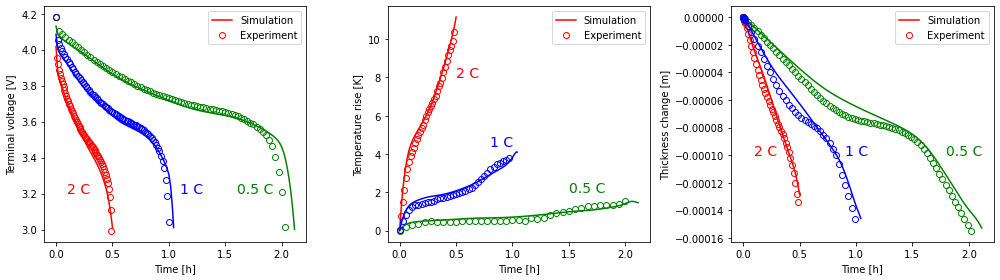

In [5]:
t_all2C = solution2C["Time [h]"].entries
V_n2C = solution2C["Terminal voltage [V]"].entries
T_n2C = solution2C["Volume-averaged cell temperature [K]"].entries - param["Initial temperature [K]"]
L_x2C = solution2C["Cell thickness change [m]"].entries

t_all1C = solution1C["Time [h]"].entries
V_n1C = solution1C["Terminal voltage [V]"].entries
T_n1C = solution1C["Volume-averaged cell temperature [K]"].entries - param["Initial temperature [K]"]
L_x1C = solution1C["Cell thickness change [m]"].entries

t_all05C = solution05C["Time [h]"].entries
V_n05C = solution05C["Terminal voltage [V]"].entries
T_n05C = solution05C["Volume-averaged cell temperature [K]"].entries - param["Initial temperature [K]"]
L_x05C = solution05C["Cell thickness change [m]"].entries
f, (ax1, ax2,ax3) = plt.subplots(1, 3 ,figsize=(14,4))
ax1.plot(t_all2C, V_n2C,'r-',label="Simulation")
ax1.plot(data_V_2C.values[::30,0]/3600, data_V_2C.values[::30,1],'ro',markerfacecolor='none',label="Experiment")
ax1.plot(t_all05C, V_n05C,'g-')
ax1.plot(data_V_05C.values[::100,0]/3600, data_V_05C.values[::100,1],'go',markerfacecolor='none')
ax1.plot(t_all1C, V_n1C,'b-')
ax1.plot(data_V_1C.values[::50,0]/3600, data_V_1C.values[::50,1],'bo',markerfacecolor='none')
ax1.legend()
#plt.xlim(0, 3600);
ax1.set_xlabel("Time [h]")
ax1.set_ylabel("Terminal voltage [V]")
ax1.text(0.1, 3.2, r'2 C', {'color': 'r', 'fontsize': 14})
ax1.text(1.1, 3.2, r'1 C', {'color': 'b', 'fontsize': 14})
ax1.text(1.6, 3.2, r'0.5 C', {'color': 'g', 'fontsize': 14})

ax2.plot(t_all2C, T_n2C,'r-',label="Simulation")
ax2.plot(data_T_2C.values[0:1754:50,0]/3600, data_T_2C.values[0:1754:50,1],'ro',markerfacecolor='none',label="Experiment")
ax2.plot(t_all05C, T_n05C,'g-')
ax2.plot(data_T_05C.values[0:7301:200,0]/3600, data_T_05C.values[0:7301:200,1],'go',markerfacecolor='none')
ax2.plot(t_all1C, T_n1C,'b-')
ax2.plot(data_T_1C.values[0:3598:100,0]/3600, data_T_1C.values[0:3598:100,1],'bo',markerfacecolor='none')
ax2.legend()
ax2.set_xlabel("Time [h]")
ax2.set_ylabel("Temperature rise [K]")
#plt.xlim(0, 3600);
ax2.text(0.5, 8, r'2 C', {'color': 'r', 'fontsize': 14})
ax2.text(0.8, 4.4, r'1 C', {'color': 'b', 'fontsize': 14})
ax2.text(1.5, 2, r'0.5 C', {'color': 'g', 'fontsize': 14})

ax3.plot(t_all2C, L_x2C,'r-',label="Simulation")
ax3.plot(data_Disp_2C.values[0:1754:5,0]/3600, data_Disp_2C.values[0:1754:5,1]-data_Disp_2C.values[0,1],'ro',markerfacecolor='none',label="Experiment")
ax3.plot(t_all05C, L_x05C,'g-')
ax3.plot(data_Disp_05C.values[0:1754:10,0]/3600, data_Disp_05C.values[0:1754:10,1]-data_Disp_05C.values[0,1],'go',markerfacecolor='none')
ax3.plot(t_all1C, L_x1C,'b-')
ax3.plot(data_Disp_1C.values[0:1754:10,0]/3600, data_Disp_1C.values[0:1754:10,1]-data_Disp_1C.values[0,1],'bo',markerfacecolor='none')
ax3.legend()
ax3.set_xlabel("Time [h]")
ax3.set_ylabel("Thickness change [m]")
ax3.text(0.1, -0.0001, r'2 C', {'color': 'r', 'fontsize': 14})
ax3.text(0.9, -0.0001, r'1 C', {'color': 'b', 'fontsize': 14})
ax3.text(1.8, -0.0001, r'0.5 C', {'color': 'g', 'fontsize': 14})
#plt.xlim(0, 3600);
f.tight_layout()
f.show()


Stress data below are from Fig. 6 in Ai et al. JES 2020 https://iopscience.iop.org/article/10.1149/2.0122001JES

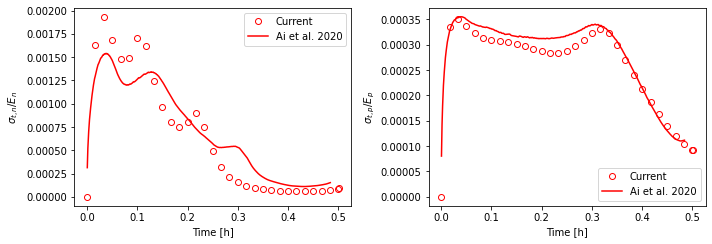

In [13]:
cs_n_xav = solution2C["X-averaged negative particle concentration [mol.m-3]"].entries
cs_p_xav = solution2C["X-averaged positive particle concentration [mol.m-3]"].entries
st_surf_n =  solution2C["Negative particle surface tangential stress"].entries
st_surf_p =  solution2C["Positive particle surface tangential stress"].entries

data_st_n_2C=pd.read_csv (path + "stn_2C.txt", delimiter= ',',header=3)
data_st_p_2C=pd.read_csv (path + "stp_2C.txt", delimiter= ',',header=3)

f, (ax1, ax2) = plt.subplots(1, 2 ,figsize=(10,3.5))
ax1.plot(t_all2C, st_surf_n[-1,:],'ro',markerfacecolor='none',label="Current")
ax1.plot(data_st_n_2C.values[:,0]/3600, data_st_n_2C.values[:,1],'r-',label="Ai et al. 2020")
ax1.legend()
#plt.xlim(0, 3600);
ax1.set_xlabel("Time [h]")
ax1.set_ylabel("$\sigma_{t,n}/E_n$")

ax2.plot(t_all2C, st_surf_p[0,:],'ro',markerfacecolor='none',label="Current")
ax2.plot(data_st_p_2C.values[0:3601,0]/3600, data_st_p_2C.values[0:3601,1],'r-',label="Ai et al. 2020")
ax2.legend()
ax2.set_xlabel("Time [h]")
ax2.set_ylabel("$\sigma_{t,p}/E_p$")
#plt.xlim(0, 3600);
f.tight_layout()
f.show()